In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, plot_confusion_matrix
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.multiclass import OneVsOneClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

import warnings

# load data and first impression

In [2]:
data = pd.read_csv('employee_promotion.csv')
data.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,52248.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.023172,63.712238,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.150450,13.521910,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,0.000000,77.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,99.000000,1.000000


## distribution plots

array([[<AxesSubplot:title={'center':'employee_id'}>,
        <AxesSubplot:title={'center':'no_of_trainings'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'previous_year_rating'}>,
        <AxesSubplot:title={'center':'length_of_service'}>,
        <AxesSubplot:title={'center':'awards_won'}>],
       [<AxesSubplot:title={'center':'avg_training_score'}>,
        <AxesSubplot:title={'center':'is_promoted'}>, <AxesSubplot:>]],
      dtype=object)

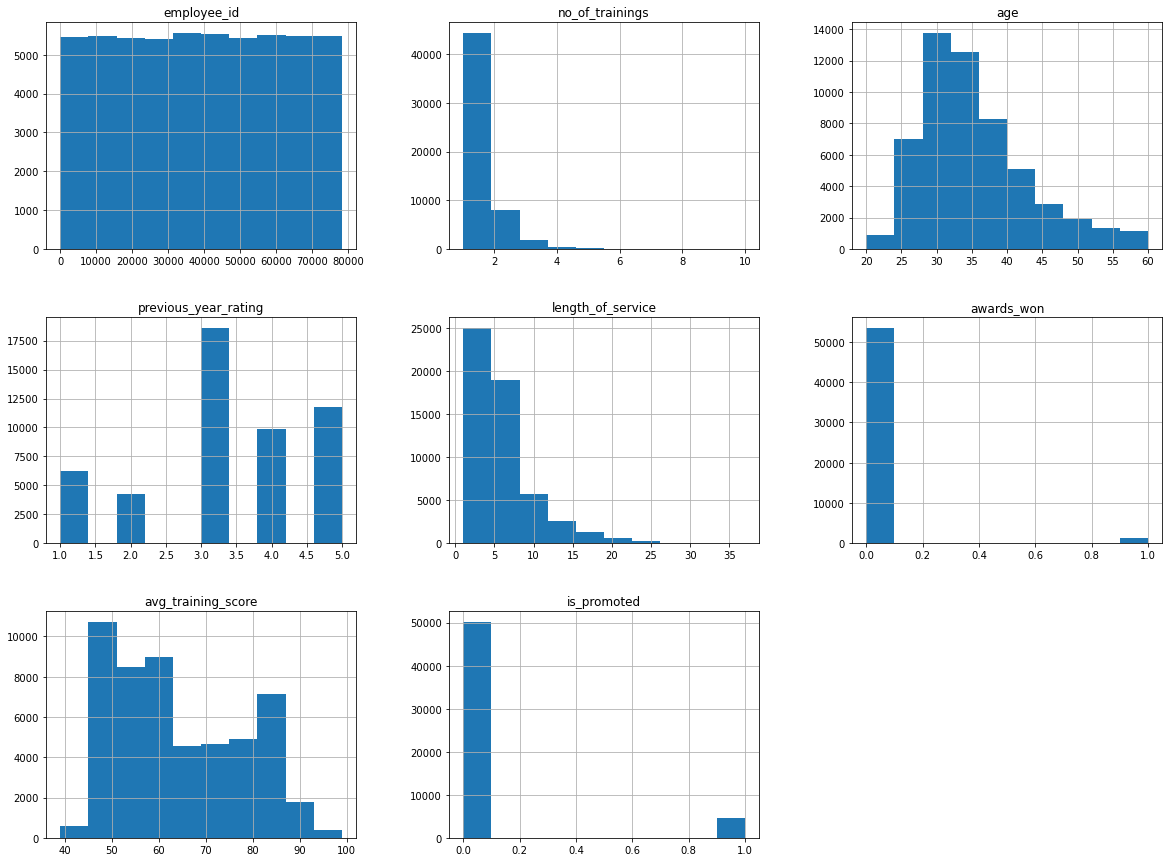

In [3]:
%matplotlib inline
data.hist(figsize=(20,15))

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  awards_won            54808 non-null  int64  
 11  avg_training_score    52248 non-null  float64
 12  is_promoted           54808 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 5.4+ MB


# fill NaN values

In [5]:
data.isna().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
awards_won                 0
avg_training_score      2560
is_promoted                0
dtype: int64

## avg_training_score

In [14]:
def get_values_fillna_cont(df, key, estimator, cv=10):


    X_data = df[df.columns[~df.isna().any()]]
    X_data = pd.get_dummies(X_data)
    y_data = df[key]

    y_train = y_data[~y_data.isna()]
    y_predict = y_data.drop(y_train.index, axis=0)

    if y_predict.isna().all() != True:
        warnings.warn('y_predict is not all NaN', category=UserWarning)

    X_train = X_data[X_data.index.isin(y_train.index)]
    X_predict = X_data[X_data.index.isin(y_predict.index)]


    score = cross_val_score(estimator, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
    
    avg_score = np.mean(score)
    if avg_score <= 0.85:
        warnings.warn(f'estimated r2 is only {avg_score}', category=UserWarning)

    print(f'predict missing values in column {key} with {avg_score} r2')

    estimator.fit(X_train,y_train)
    predictions = estimator.predict(X_predict)
    predictions = np.round(predictions)

    value = dict()
    for idx, val in zip(X_predict.index, predictions):
        value[idx] = val
    return value
# get_values_fillna_cont(data, 'avg_training_score', RandomForestRegressor(n_jobs=-1))

KeyboardInterrupt: 

In [7]:
def fill_na_cont(df):
    columns = (
        data
        [data.columns[data.isna().any()]]
        .select_dtypes(float)
    ).columns
    
    for column in columns:        
        values = get_values_fillna_cont(data, column, RandomForestRegressor(n_jobs=-1))    
        df[column] = df[column].fillna(values) 
    return df

# data = fill_na_cont(data)

In [42]:
def get_values_fillna_cat(df, key, estimator, cv=10):
    '''
    df = data
    key = 'education'
    estimator = RandomForestClassifier(n_jobs=-1, verbose=True)
    cv=3
'''
    scaler = StandardScaler()

    X_data = df[df.columns[~df.isna().any()]]
    X_data = pd.get_dummies(X_data)

    
    y_data = df[key]
    y_train = y_data[~y_data.isna()]
    y_predict = y_data.drop(y_train.index, axis=0)


    if y_predict.isna().all() != True:
        warnings.warn('y_predict is not all NaN', category=UserWarning)

    X_train = X_data[X_data.index.isin(y_train.index)]
    X_predict = X_data[X_data.index.isin(y_predict.index)]
    predict_index = X_predict.index
    X_train = scaler.fit_transform(X_train)
    y_train = LabelEncoder().fit_transform(y_train)
    X_predict = scaler.fit_transform(X_predict)


    fold = StratifiedKFold(n_splits=cv)
    cv_predict = cross_val_predict(estimator, X_train, y_train, cv=fold, n_jobs=-1)
    
    print(y_train.shape, cv_predict.shape)
    
    roc_auc = roc_auc_score(y_train, pd.get_dummies(cv_predict), multi_class='ovr')
    acc = accuracy_score(y_train, cv_predict)
    
    print(f'ROC AUC: {roc_auc}, ACC: {acc}')
    print(confusion_matrix(y_train, cv_predict))

    estimator.fit(X_train, y_train)
    y_predict = estimator.predict(X_predict)
    
    values = dict()
    for idx, val in zip(predict_index, y_predict):
        values[idx] = val

    return values

get_values_fillna_cat(data, 'education', SVC())

(52399,) (52399,)
ROC AUC: 0.6037545886401903, ACC: 0.7397851104028703
[[34313    37  2319]
 [  662   143     0]
 [10614     3  4308]]


{10: 0,
 21: 0,
 32: 0,
 43: 0,
 82: 0,
 87: 0,
 90: 0,
 189: 0,
 204: 0,
 231: 0,
 245: 0,
 277: 0,
 323: 0,
 336: 0,
 352: 0,
 354: 0,
 359: 0,
 365: 0,
 397: 0,
 415: 0,
 416: 0,
 475: 0,
 508: 0,
 514: 0,
 570: 0,
 574: 0,
 586: 0,
 589: 0,
 597: 2,
 609: 0,
 629: 0,
 670: 0,
 678: 0,
 690: 2,
 699: 0,
 714: 0,
 738: 0,
 793: 0,
 794: 0,
 817: 0,
 843: 0,
 866: 0,
 867: 0,
 880: 0,
 887: 0,
 892: 0,
 903: 0,
 919: 0,
 947: 0,
 1015: 2,
 1079: 0,
 1119: 0,
 1123: 0,
 1139: 0,
 1160: 0,
 1169: 0,
 1175: 0,
 1181: 0,
 1188: 0,
 1193: 0,
 1197: 0,
 1204: 2,
 1207: 0,
 1223: 0,
 1254: 0,
 1256: 0,
 1299: 0,
 1333: 0,
 1339: 0,
 1356: 0,
 1373: 0,
 1413: 0,
 1467: 0,
 1501: 0,
 1520: 0,
 1524: 0,
 1550: 0,
 1559: 0,
 1581: 0,
 1585: 2,
 1591: 0,
 1601: 0,
 1643: 0,
 1657: 0,
 1664: 0,
 1708: 0,
 1715: 0,
 1719: 0,
 1727: 0,
 1737: 0,
 1748: 0,
 1752: 0,
 1809: 0,
 1829: 0,
 1836: 0,
 1839: 0,
 1845: 2,
 1868: 0,
 1885: 0,
 1887: 0,
 1897: 0,
 1921: 0,
 1964: 2,
 1969: 0,
 1984: 0,
 1999: